# Counterfactual predictions for mapping variables

Up until this point, we have been using the function `eensight.methods.prediction.activity.estimate_activity` to estimate the activity levels given the energy consumption data. However, there is a flaw: 

>`estimate_activity` assumes that the highest consumption values (conditioned on the external variables such as the weather) always correspond to activity levels of `1`. 

While this is correct for the baseline period, *what happens when there is an event that changes activity density*? 

As an example, fewer people may use the building due to restrictions imposed to deal with the COVID 19 pandemic. It does not make sense to continue assuming that the maximum value of activity remains `1`. Instead, we need a strategy for adjusting the range of the activity levels to the new conditions.

The strategy of `eensight` is to reverse the way the activity estimation and the energy consumption prediction work:

* For events that affect **impact variables** (such as an energy retrofit): 

  1. An energy consumption model is trained on pre-event data. 
     <br/>
  
  2. The energy consumption model that was trained on pre-event data is used to create counterfactual predictions given post-event activity levels and external conditions.


* For events that affect **mapping variables**:

  1. The pre-event consumption predictive model is used to estimate post-event activity levels. This is done by finding the activity levels that force the output of the model to match with the currently observed energy consumption. Note that if only mapping variables have changed, the consumption model is still accurate when predicting energy consumption.  
     <br/>

  2. The pre-event consumption predictive model is used to create counterfactual predictions given the estimated post-event occupancy levels. 
  
This section explains the relevant `eensight` pipeline (called `adjust`) through an example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from catboost import CatBoostRegressor

from eensight.methods.prediction.baseline import UsagePredictor
from eensight.methods.prediction.activity import adjust_activity, estimate_activity
from eensight.utils import load_catalog

plt.style.use("bmh")

%matplotlib inline

A utility function:

In [3]:
def get_colorbars(fig):
    cbs = []
    for ax in fig.axes:
        cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))
    return [a.colorbar for a in cbs]

## The *b05* dataset

The *b05* data corresponds to the building from the [Dryad Dataset](https://doi.org/10.7941/D1N33Q). 

Start with the `train` data:

In [16]:
catalog = load_catalog(store_uri="../../../data", site_id="b05", namespace="train")

X_train = catalog.load("train.preprocessed-features")
y_train = catalog.load("train.preprocessed-labels")

The following plot presents the energy consumption of the selected dataset as a function of the outdoor temperature:

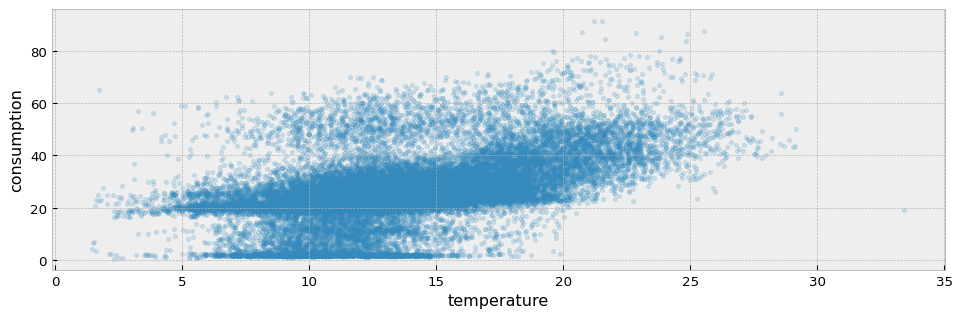

In [17]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10, alpha=0.2)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

The first step is to fit an autoencoding model for the `train` period's energy consumption data. Start by estimating activity:

In [18]:
act_train = estimate_activity(
    X_train, 
    y_train, 
    non_occ_features="temperature",
    exog="temperature"
)

The estimated activity levels are presented below:

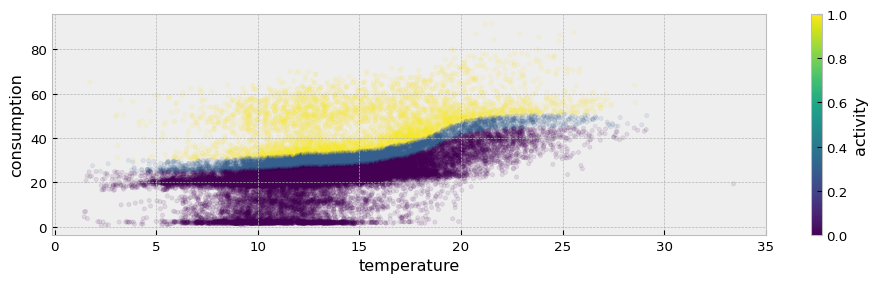

In [19]:
plot_data = pd.concat(
    [
        X_train[["temperature"]], 
        y_train,
        act_train.to_frame("activity")
    ], 
    axis=1
).sort_values(by="temperature")

fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

plot_data.plot.scatter(
    "temperature", 
    "consumption", 
    color="activity", 
    colormap='viridis', 
    alpha=0.1, 
    s=10, 
    ax=ax
)

color_bar = get_colorbars(fig)[0]
color_bar.set_alpha(1)
color_bar.draw_all()

Then, fit a consumption model using weather and activity levels as features:

In [20]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
        
    ], 
    axis=1
)

model = UsagePredictor(skip_calendar=True).fit(X_train_act, y_train)

We can use the `scores_` attribute to see how well the model fits on the training and validation datasets: 

In [21]:
model.scores_

{
    'learn': {'RMSE': 6.121432342155757, 'CVRMSE': 0.23162542663771996},
    'validation': {'RMSE': 7.531196416499583, 'CVRMSE': 0.3385382692652784}
}

Next, we assume that an event took place that changed activity intensity:

In [22]:
catalog = load_catalog(store_uri="../../../data", site_id="b05", namespace="apply")

X_apply = catalog.load("apply.preprocessed-features")
y_apply = catalog.load("apply.preprocessed-labels")

Using the first year's data is enough:

In [23]:
X_apply = X_apply[X_apply.index.year == 2019]
y_apply = y_apply.loc[X_apply.index]

Although we don't know the exact reason behind the differences in the `train` and `apply` data, it seems that there is an area in the `train` consumption data (colored in yellow) that is missing any observations in the `apply` consumption data:

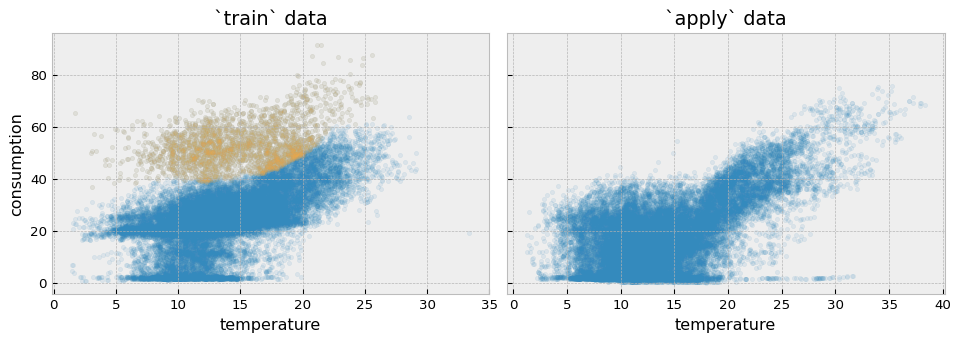

In [12]:
BOOST_PARAMS = {
    "loss_function": "Quantile:alpha=0.999",
    "iterations": 600,
    "depth": 3,
    "allow_writing_files": False,
    "verbose": False,
}

threshold_model = CatBoostRegressor(**BOOST_PARAMS)
threshold_model = threshold_model.fit(X_apply[["temperature"]], y_apply)

mask = (y_train["consumption"] >= 
        pd.Series(threshold_model.predict(X_train[["temperature"]]), index=X_train.index)
)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3.54), dpi=96)
fig.subplots_adjust(wspace=0.04)

ax1.scatter(
    X_train["temperature"], 
    y_train["consumption"], 
    s=10, 
    alpha=0.1
)

ax1.scatter(
    X_train.loc[mask, "temperature"], 
    y_train.loc[mask, "consumption"], 
    color="#feb24c", 
    s=10, 
    alpha=0.1
)

ax1.set_xlabel("temperature")
ax1.set_ylabel("consumption")
ax1.set_title("`train` data")

ax2.scatter(X_apply["temperature"], y_apply["consumption"], s=10, alpha=0.1)
ax2.set_xlabel("temperature")
ax2.set_title("`apply` data")

We can assume that something that used to happen inside the building during the `train` period does not happen any more in the `apply` period. In principle, activity changes are reflected in the `activity` variable. 

First, let's estimate the activity levels in the `apply` period using the `estimate_activity` function:

In [13]:
act_apply = estimate_activity(
    X_apply, 
    y_apply, 
    non_occ_features="temperature",
    exog="temperature"
)

We can plot the estimated activity levels for the `train` and the `apply` data side by side:

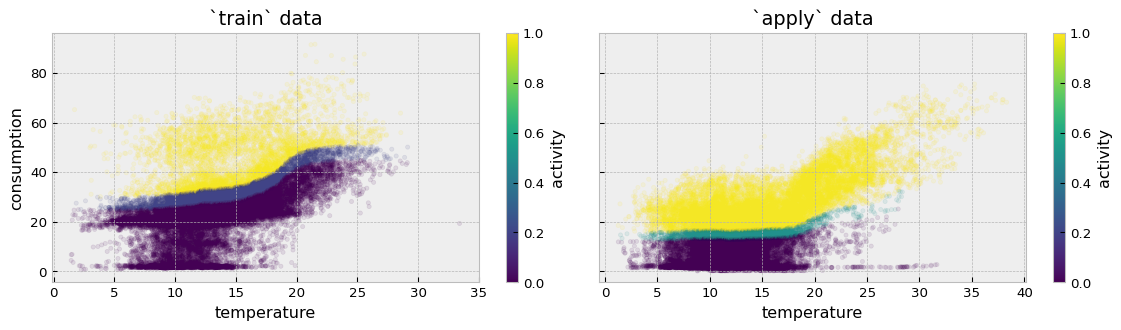

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3.54), dpi=96)

plot_data = pd.concat(
    [
        X_train[["temperature"]], 
        y_train,
        act_train.to_frame("activity"),
    ], 
    axis=1
).sort_values(by="temperature")

plot_data.plot.scatter(
    "temperature", 
    "consumption", 
    color="activity", 
    alpha=0.1,
    colormap='viridis', 
    s=10, 
    ax=ax1
)

ax1.set_xlabel("temperature")
ax1.set_ylabel("consumption")
ax1.set_title("`train` data")

plot_data = pd.concat(
    [
        X_apply[["temperature"]], 
        y_apply,
        act_apply.to_frame("activity"),
    ], 
    axis=1
).sort_values(by="temperature")

plot_data.plot.scatter(
    "temperature", 
    "consumption", 
    color="activity", 
    alpha=0.1, 
    colormap='viridis', 
    s=10, 
    ax=ax2
)

ax2.set_xlabel("temperature")
ax2.set_title("`apply` data")

for color_bar in get_colorbars(fig):
    color_bar.set_alpha(1)
    color_bar.draw_all()

plt.tight_layout()

The problem with the plots above is that activity levels **do not correctly map** between the `train` and the `apply` periods. For a counterfactual model to work appropriately for this dataset, similar temperature and consumption values should correspond to similar activity levels (similar colors on the two plots).

For events that affect **mapping variables**, the pre-event consumption predictive model is used to estimate post-event activity levels. This is done by finding the activity levels that force the output of the model to match with the currently observed energy consumption. This functionality is provided by the function `eensight.methods.prediction.activity.adjust_activity`.

`adjust_activity` needs the post-event data, as well as an energy consumption predictive model that was trained on pre-event data:  

In [26]:
act_apply_adj = adjust_activity(X_apply, y_apply, model, non_occ_features="temperature")

Let's put all activity estimates side by side:

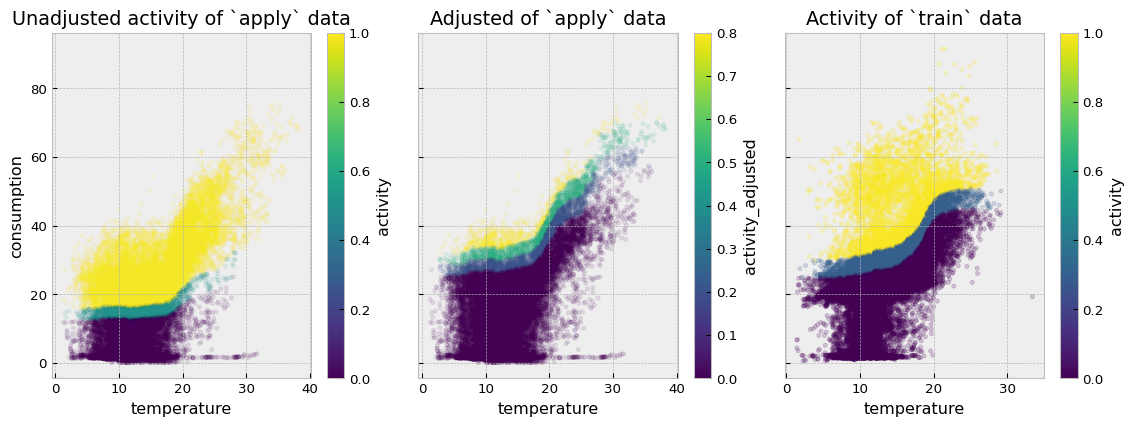

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4.54), dpi=96)

plot_data = pd.concat(
    [
        X_apply[["temperature"]], 
        y_apply,
        act_apply.to_frame("activity"),
        act_apply_adj.to_frame("activity_adjusted")
    ], 
    axis=1
).sort_values(by="temperature")

plot_data.plot.scatter("temperature", "consumption", color="activity", 
                         alpha=0.1, colormap='viridis', s=10, ax=ax1
)
plot_data.plot.scatter("temperature", "consumption", color="activity_adjusted", 
                         alpha=0.1, colormap='viridis', s=10, ax=ax2
)

plot_data = pd.concat(
    [
        X_train[["temperature"]], 
        y_train,
        act_train.to_frame("activity"),
    ], 
    axis=1
).sort_values(by="temperature")
plot_data.plot.scatter("temperature", "consumption", color="activity", 
                       colormap='viridis', alpha=0.2, s=10, ax=ax3
)

ax1.set_title("Unadjusted activity of `apply` data")
ax2.set_title("Adjusted of `apply` data")
ax3.set_title("Activity of `train` data")

for color_bar in get_colorbars(fig):
    color_bar.set_alpha(1)
    color_bar.draw_all()

plt.tight_layout()

Finally, the pre-event consumption predictive model is used to create counterfactual predictions given the estimated post-event occupancy levels:

In [28]:
X_counter = pd.concat(
    [
        X_apply,
        act_apply_adj.to_frame("activity")
        
    ], 
    axis=1
)

prediction = model.predict(X_counter)

The impact of the event is:

In [29]:
impact = prediction - y_apply["consumption"]

Typically, the impact is visualized as a cumulative variable:

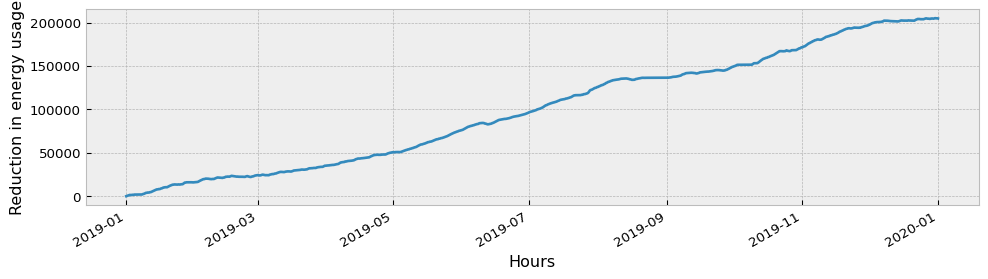

In [30]:
fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

impact.cumsum().plot(ax=ax)
ax.set_xlabel('Hours')
ax.set_ylabel('Reduction in energy usage')

--------------